Unzip data.zip in the same directory, where course_work.ipynb is placed

In [1]:
#!pip install xgboost

___

###  Курсовая работа по курсу Geekbrains "Теория вероятностей и математическая статистика"

#### тема: 
- проверить гипотезу о том, что скор моделей, использованных для предсказания целевой переменной, статистически значимо отличается на кроссвалидационных фолдах

Датасет взят с соревнования на сайте hackerrank.com  

Предсказать степень выгорания (Burn Rate) работников

- **Employee ID** - Unique Id of the employee
- **Date of Joining** - Date on which the employee joined the company
- **Gender** - Gender of the employee
- **Company Type** - Type of company eg: Service based, product based etc.
- **WFH Setup Available** - Whether proper work from home setup is available or not 
- **Designation** - Seniority level of the employee in codes
- **Resource Allocation** - Hours allocated per day
- **Mental Fatigue Score** - Stress rating provided by employees
- **Burn Rate** - Rate of saturation or burn out rate [Target]

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore')

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score
from scipy.stats import ttest_rel, probplot

In [4]:
def missing_data(df: pd.DataFrame) -> pd.DataFrame:
    '''
    returns dataframe of missing values in descending order
    '''
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / 
               df.isnull().count()).sort_values(ascending=False)
    md = pd.concat([total, percent], axis=1, 
                   keys=['Total', 'Missing Percent'])
    md['Missing Percent'] = md['Missing Percent'].apply(lambda x: x * 100)
    return md

In [5]:
def plot_scatter(df: pd.DataFrame, target, fsize=20):
    """
    plot scatter plots vs target column
    df: dataframe
    target: target column
    fsize: figsize value (currently it is square figure)
    """
    y = int(np.round(np.sqrt(len(df.columns))))
    x = len(df.columns) - y
    position = range(1,x + y + 1)
    fig = plt.figure(figsize=(fsize, fsize))
    for i in range(x + y):
        ax = fig.add_subplot(x, y, position[i])
        ax.scatter(df[df.columns[i]], df[target], alpha=0.4)
        ax.set_xlabel(df.columns[i])
        ax.set_ylabel(target)
    plt.show()

In [6]:
TEST_DATA = './train.csv'
TARGET = 'Burn Rate'

In [7]:
df = pd.read_csv(TEST_DATA)
df.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [8]:
n_all = df.shape[0]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee ID           22750 non-null  object 
 1   Date of Joining       22750 non-null  object 
 2   Gender                22750 non-null  object 
 3   Company Type          22750 non-null  object 
 4   WFH Setup Available   22750 non-null  object 
 5   Designation           22750 non-null  float64
 6   Resource Allocation   21369 non-null  float64
 7   Mental Fatigue Score  20633 non-null  float64
 8   Burn Rate             21626 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.6+ MB


In [10]:
missing_data(df)

,Total,Missing Percent
Mental Fatigue Score,2117,9.305495
Resource Allocation,1381,6.070330
Burn Rate,1124,4.940659
Employee ID,0,0.000000
Date of Joining,0,0.000000
Gender,0,0.000000
Company Type,0,0.000000
WFH Setup Available,0,0.000000
Designation,0,0.000000


Дропнем строки с пропущенными значениями

In [11]:
df.dropna(inplace=True)

In [12]:
n_rest = df.shape[0]
(n_all - n_rest) * 100 / n_all

18.285714285714285

Потеряли чуть больше 18 процентов данных. Для выборки размером около 20 тысяч может быть приемлемо 

ID работника для нас особой роли не играет

In [13]:
df.drop('Employee ID', axis=1, inplace=True)

In [14]:
df['Date of Joining'] = pd.to_datetime(df['Date of Joining'])

Оценим признаки по колличеству принимаемых значений

In [15]:
for col in df.columns:
    print(col, ' - ', df[col].nunique())

Date of Joining  -  366
Gender  -  2
Company Type  -  2
WFH Setup Available  -  2
Designation  -  6
Resource Allocation  -  10
Mental Fatigue Score  -  101
Burn Rate  -  101


In [16]:
for col in df.columns:
    if df[col].nunique() <= 10:
        print(col, ' - ', df[col].unique())

Gender  -  ['Female' 'Male']
Company Type  -  ['Service' 'Product']
WFH Setup Available  -  ['No' 'Yes']
Designation  -  [2. 1. 3. 0. 4. 5.]
Resource Allocation  -  [ 3.  2.  1.  7.  4.  6.  5.  8. 10.  9.]


In [17]:
df.describe()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
count,18590.000000,18590.000000,18590.000000,18590.000000
mean,2.179398,4.486552,5.732173,0.452444
std,1.133148,2.044848,1.920547,0.197848
min,0.000000,1.000000,0.000000,0.000000
25%,1.000000,3.000000,4.600000,0.320000
50%,2.000000,4.000000,5.900000,0.450000
75%,3.000000,6.000000,7.100000,0.590000
max,5.000000,10.000000,10.000000,1.000000


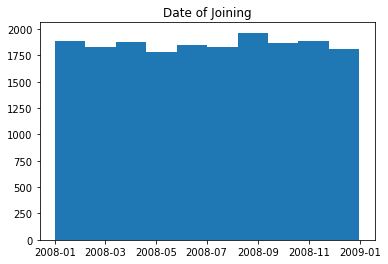

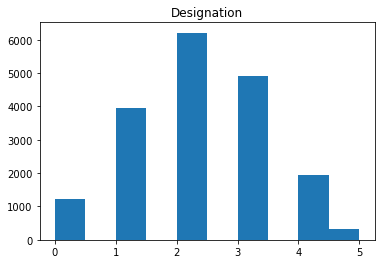

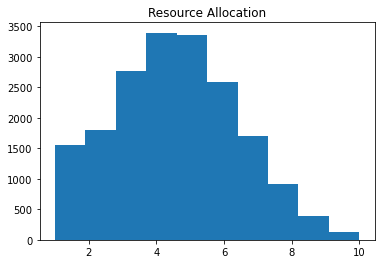

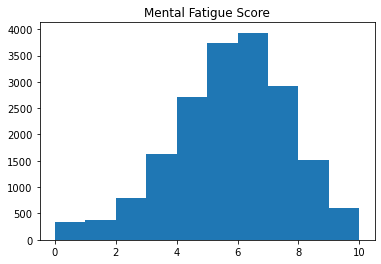

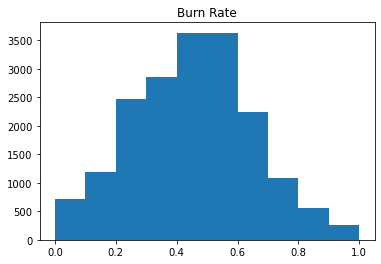

In [18]:
for col in df.select_dtypes(exclude='object').columns:
    plt.hist(df[col], bins=10)
    plt.title(label=col)
    plt.show()

Особых выбросов не видим. Дата устройства на работу вообще распределена практически равномерно по всей выборке.

___

Посмотрим распределение относительно целевой переменной

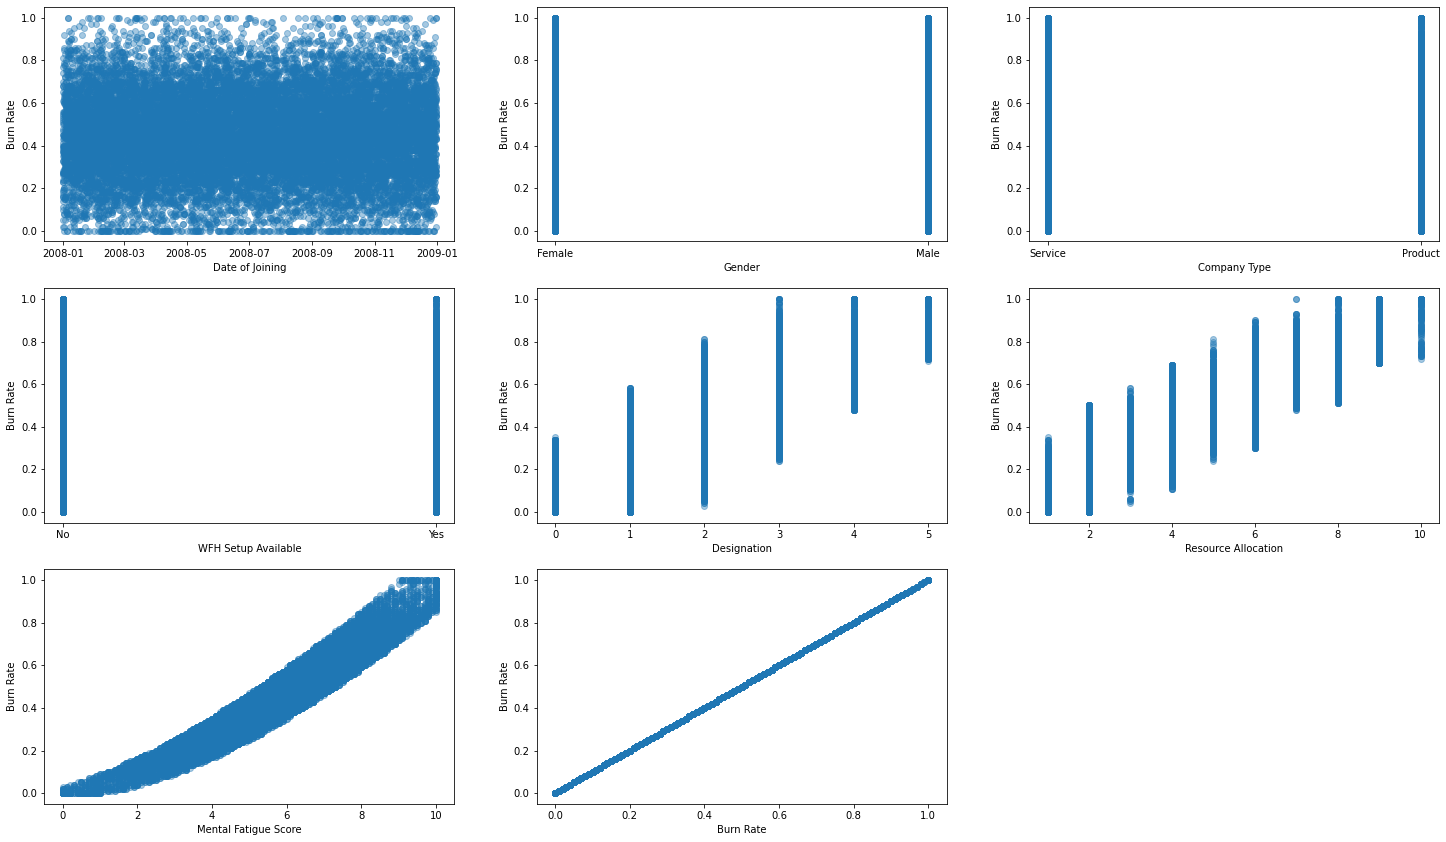

In [19]:
plot_scatter(df, TARGET, fsize=25)

Исходя из графиков можно сделать выводы, что столбцы Date of Joining, Gender, Company Type, WFH Setup Available слабо влияют на целевую переменную.

Посмотрим на них отдельно

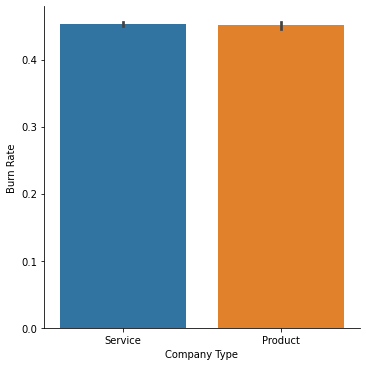

In [20]:
sns.catplot(x='Company Type', 
            y=TARGET, 
            kind='bar', 
            data=df);

In [21]:
df.groupby('Company Type')['Burn Rate'].mean()

Company Type
Product    0.450835
Service    0.453292
Name: Burn Rate, dtype: float64

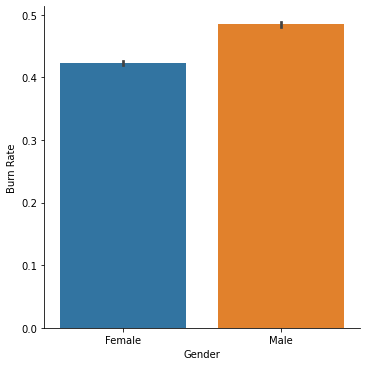

In [22]:
sns.catplot(x='Gender', 
            y=TARGET, 
            kind='bar', 
            data=df);

In [23]:
df.groupby('Gender')['Burn Rate'].mean()

Gender
Female    0.422938
Male      0.484967
Name: Burn Rate, dtype: float64

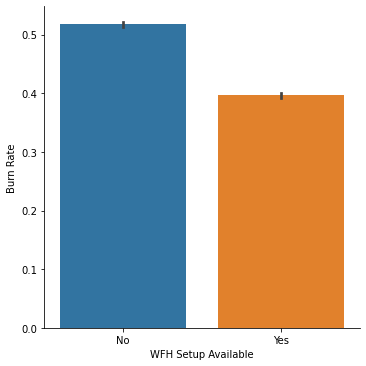

In [24]:
sns.catplot(x='WFH Setup Available', 
            y=TARGET, 
            kind='bar', 
            data=df);

In [25]:
df.groupby('WFH Setup Available')['Burn Rate'].mean()

WFH Setup Available
No     0.518227
Yes    0.396303
Name: Burn Rate, dtype: float64

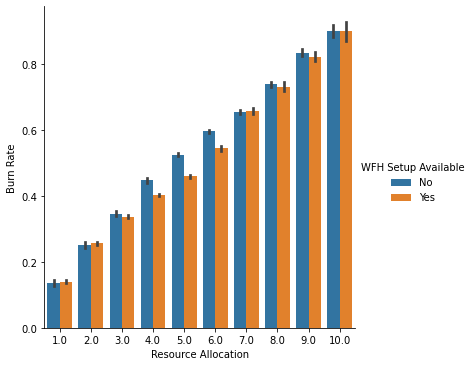

In [26]:
sns.catplot(x='Resource Allocation', 
            y=TARGET,
            hue='WFH Setup Available',
            kind='bar', 
            data=df);

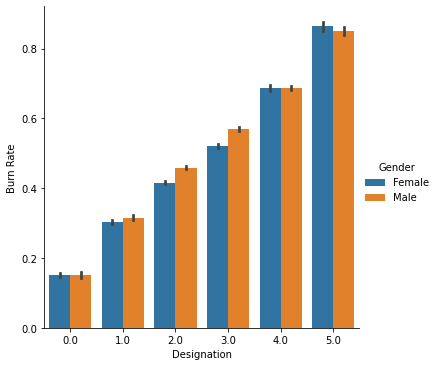

In [27]:
sns.catplot(x='Designation', 
            y=TARGET,
            hue='Gender',
            kind='bar', 
            data=df);

Промежуточные выводы:  
- Особое значение имеют столбцы Designation, Resource Allocation, Mental Fatigue Score, имеющие связь с целевой переменной близую к линейной.
- WFH Setup Available может иметь определенное значение, так как на средних уровнях Resource Allocation есть разница по этому признаку
- По Gender есть определенные вопросы, по Designation на значениях 2 и 3 есть различие, но небольшое. Возможно шум

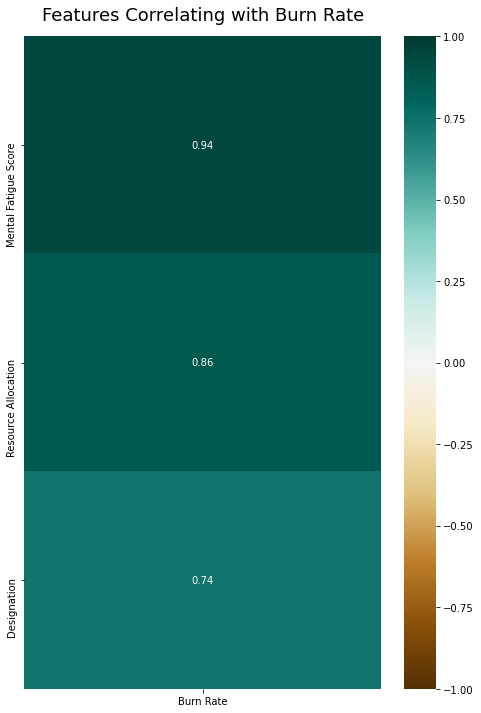

In [28]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[[TARGET]].sort_values(by=TARGET, 
                                                      ascending=False)[1:], 
                      vmin=-1, 
                      vmax=1, 
                      annot=True, 
                      cmap='BrBG')
heatmap.set_title('Features Correlating with Burn Rate', 
                  fontdict={'fontsize':18}, pad=16);

Дропнем признак Date of Joining

In [29]:
df.drop('Date of Joining', axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

В тренировочные выборки включим только те признаки, которые считаем релевантными

In [30]:
y = df[TARGET]
x = df.drop(TARGET, axis=1).select_dtypes(exclude='object')

___

Сравним работу двух моделей: XGBoost и RandomForest. Для этого разобьем выбрку на 50 фолдов для кроссвалидации, а затем применим критерий Стьюдента для оценки статистической значимости в различии работы этих моделей

In [31]:
rf_100_trees = np.array([])
xgb_100_trees = np.array([])
for i in range(10):
    fold = KFold(n_splits=5, shuffle=True, random_state=i)
    rf_scores_on_this_split = cross_val_score(
        estimator=RandomForestRegressor(n_estimators=100), 
        X=x, y=y, 
        cv=fold, 
        scoring='r2')
    rf_100_trees = np.append(rf_100_trees, rf_scores_on_this_split)
    
    xgb_scores_110_trees_on_this_split = cross_val_score(
        estimator=XGBRegressor(n_estimators=100), 
        X=x, y=y, 
        cv=fold, 
        scoring='r2')
    xgb_100_trees = np.append(xgb_100_trees, 
                              xgb_scores_110_trees_on_this_split)

Для применения критерия Стьюдента необходимо:
- нормальное распределение, отсутствие выбросов
- размер выборки не меньше 30 наблюдений

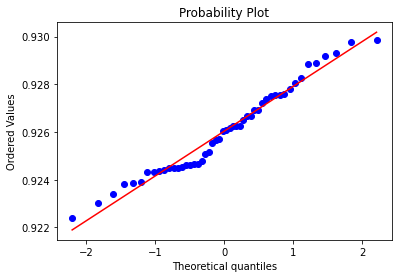

In [32]:
probplot(xgb_100_trees, dist='norm', plot=plt);

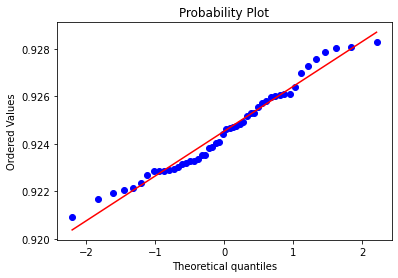

In [33]:
probplot(rf_100_trees, dist='norm', plot=plt);

Требование по нормальности выборок выполняются с достаточной точностью

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны  
$\large H_0: \: \mu_1 = \mu_2$  
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются  
$\large H_1: \: \mu_1 \ne \mu_2$  
* Критерий: критерий Стьюдента (t-тест)
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Статистика t-критерия имеет следующий вид:  

$$ T(X_1^n,X_2^n) = \frac{E(X_1)-E(X_2)}{S/\sqrt{n}} $$  

где $X_1^n,X_2^n$ списки значений метрики по тестовым фолдам для первой и второй модели соответственно, S – дисперсия попарных разностей, n – число фолдов.

In [34]:
alpha = 0.05
test = ttest_rel(xgb_100_trees, rf_100_trees)
if test[1] < alpha:
    print('Отвергаем нулевую гипотезу. Модели отработали со статистически значимой разницей ')
    print(f'Скор первой модели больше\nСреднее результатов первой модели '
          f'{np.mean(xgb_100_trees):.4f}') if test[0] > 0 else print('Скор '
          f'второй модели больше\nСреднее результатов второй модели '
          f'{np.mean(rf_100_trees):.4f}')
else:
    print('Отвергнуть нулевую гипотезу мы не можем, разница в моделях статистически не значима')
print(f'Значение статистики - {test[0]}\np-value - {test[1]}')

Отвергаем нулевую гипотезу. Модели отработали со статистически значимой разницей 
Скор первой модели больше
Среднее результатов первой модели 0.9260
Значение статистики - 46.36561781849459
p-value - 3.8523230052967336e-42


___

p.s. На данном датасете вполне можно использовать модель линейной регрессии, которая дает вполне сравнимые результаты

In [35]:
scores = np.array([])
for i in range(10):
    fold = KFold(n_splits=5, shuffle=True, random_state=i)
    scores_on_this_split = cross_val_score(
            estimator=LinearRegression(), X=x, y=y,
            cv=fold, scoring='r2')
    scores = np.append(scores, scores_on_this_split)
np.mean(scores)

0.9196736514790399